In [1]:
import synthetic_data
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import random

In [2]:
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

##### train and test data:

context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()


X_train, y_train, dist_train = None, None, []
X_test, y_test, dist_test = None, None, []

for _ in range(10000):
    norm_context, distribution = context_generator.get_context(True)
    dist_train.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 
    X_train = norm_context if X_train is None else np.concatenate((X_train, norm_context), axis=0)
    y_train = [[outcome]] if y_train is None else np.concatenate( (y_train, [[outcome]]), axis=0)

for _ in range(10000):
    norm_context, distribution = context_generator.get_context(True)
    dist_test.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 
    X_test = norm_context if X_test is None else np.concatenate((X_test, norm_context), axis=0)
    y_test = [[outcome]] if y_test is None else np.concatenate( (y_test, [[outcome]]), axis=0)

##### deployment data:

context_generator.set_b(0.15)
X_depl, y_depl, dist_depl = None, None, []
X_depl2, y_depl2, dist_depl2 = None, None, []

for _ in range(1000):
    norm_context, distribution = context_generator.get_context(True)
    dist_depl.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 
    X_depl = norm_context if X_depl is None else np.concatenate((X_depl, norm_context), axis=0)
    y_depl = [[outcome]] if y_depl is None else np.concatenate( (y_depl, [[outcome]]), axis=0)

for _ in range(1000):
    norm_context, distribution = context_generator.get_context(True)
    dist_depl2.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 
    X_depl2 = norm_context if X_depl2 is None else np.concatenate((X_depl2, norm_context), axis=0)
    y_depl2 = [[outcome]] if y_depl2 is None else np.concatenate( (y_depl2, [[outcome]]), axis=0)

print( X_train.shape , y_train.shape )
print( X_test.shape , y_test.shape )
print( X_depl.shape , y_depl.shape )
print( X_depl2.shape , y_depl2.shape )

(10000, 2) (10000, 1)
(10000, 2) (10000, 1)
(1000, 2) (1000, 1)
(1000, 2) (1000, 1)


In [4]:
class OriginalNetwork(nn.Module):
    def __init__(self,  d, m):
        super(OriginalNetwork, self).__init__()
        self.fc1 = nn.Linear(d, m)
        self.activate1 = nn.Tanh() #nn.ReLU()
        self.fc2 = nn.Linear(m, m)
        self.activate2 = nn.Tanh() #nn.ReLU()
        self.fc3 = nn.Linear(m, m)
        self.activate3 = nn.Tanh() #nn.ReLU()
        self.fc4 = nn.Linear(m, 1)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc4.weight, mean=0, std=0.1)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)
    def forward(self, x):
        x = self.fc4( self.activate3( self.fc3( self.activate2( self.fc2( self.activate1( self.fc1( x ) ) ) ) ) ) )
        # x = self.fc2( self.activate1( self.fc1(x) ) ) 
        return x

# Set the random seed for reproducibility
torch.manual_seed(41)

# Create the model instance
model = OriginalNetwork(2, 20).to('cuda')

# Define the loss function (mean squared error) and optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay = 0 )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)

for _ in range(1000):

    model.train()

    outputs = model( torch.tensor(X_train).to('cuda').float() ) 
    loss = nn.MSELoss()(outputs, torch.tensor(y_train).to('cuda').float() )
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### test and deployment loss:
    model.eval()
    with torch.no_grad():
        outputs_test = model( torch.tensor(X_test).to('cuda').float() ).to('cpu').float() 
        loss_test = nn.MSELoss()(outputs_test, torch.tensor(y_test).to('cpu').float() )

        outputs_depl = model( torch.tensor(X_depl).to('cuda').float() ).to('cpu').float() 
        loss_depl = nn.MSELoss()(outputs_depl, torch.tensor(y_depl).to('cpu').float() )

    if _ % 10 == 0 :
        scheduler.step()
        print(f'Epoch {_}, Train loss: {loss.item():.4f}, Test loss: {loss_test.item():.4f}, Depl loss: {loss_depl.item():.4f}')

# torch.save(model.state_dict(), './models/quintic.pth')

Epoch 0, Train loss: 0.4850, Test loss: 0.1610, Depl loss: 0.1493
Epoch 10, Train loss: 0.1152, Test loss: 0.1608, Depl loss: 0.1441
Epoch 20, Train loss: 0.0937, Test loss: 0.0740, Depl loss: 0.0849
Epoch 30, Train loss: 0.0531, Test loss: 0.0660, Depl loss: 0.0917
Epoch 40, Train loss: 0.0443, Test loss: 0.0481, Depl loss: 0.0648
Epoch 50, Train loss: 0.0414, Test loss: 0.0489, Depl loss: 0.0623
Epoch 60, Train loss: 0.0365, Test loss: 0.0429, Depl loss: 0.0564
Epoch 70, Train loss: 0.0290, Test loss: 0.0331, Depl loss: 0.0570
Epoch 80, Train loss: 0.0190, Test loss: 0.0203, Depl loss: 0.0550
Epoch 90, Train loss: 0.0150, Test loss: 0.0155, Depl loss: 0.0584
Epoch 100, Train loss: 0.0126, Test loss: 0.0135, Depl loss: 0.0555
Epoch 110, Train loss: 0.0148, Test loss: 0.0190, Depl loss: 0.0639
Epoch 120, Train loss: 0.0120, Test loss: 0.0236, Depl loss: 0.0668
Epoch 130, Train loss: 0.0113, Test loss: 0.0135, Depl loss: 0.0633
Epoch 140, Train loss: 0.0086, Test loss: 0.0116, Depl loss

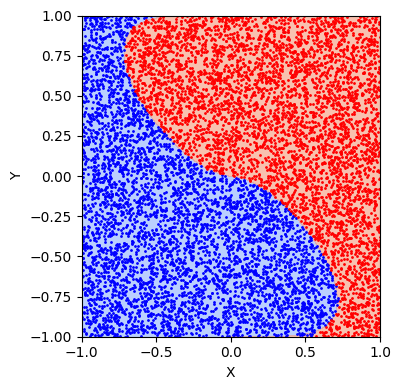

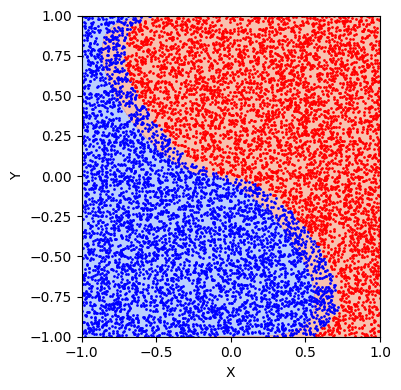

In [11]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
for idx, data in enumerate( [ (X_test,outputs_test), (X_depl, outputs_depl) ] ):

    plt.figure(figsize=(4, 4))

    b = 0 if idx == 0 else 0.15
    decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)

    plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

    contexts = np.array( [ context_generator.denormalize(i) for i in data[0] ] ).squeeze(1)

    pred_action0 = [ i[0] if i[0] > 0.5 else np.nan for i in data[1]  ]
    indices_predaction0 = np.where(~np.isnan(pred_action0))[0]
    pred_action1 = [ i[0] if i[0] <= 0.5 else np.nan for i in data[1]  ]
    indices_predaction1 = np.where(~np.isnan(pred_action1))[0]

    plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='blue', label='Predicted Points')
    plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='red', label='Predicted Points')

    # Add labels and title to the plot
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title(' Decision Boundary')
    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.ylim((-1,1))
    plt.xlim((-1,1))

    # Save the figure to a file with tight layout and 380 DPI
    plt.savefig('./figures/decision_boundary_{}.png'.format(idx), dpi=380, bbox_inches='tight')

In [7]:
import numpy as np
import random
import torch
import cbpside
import rand_cbpside
import synthetic_data
import neural_lin_cbpside_disjoint
import rand_neural_lin_cbpside_disjoint
import games

def get_feedback( game, action, outcome ):
    return game.FeedbackMatrix[ action ][ outcome ]

np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()
context_generator.set_b(0.15)

game = games.label_efficient( )

lbd_neural = 0
lbd_reg = 1

sigma = 1/8
K = 10
epsilon = 10e-7
alg = rand_neural_lin_cbpside_disjoint.CBPside( game,  1.01, lbd_neural, lbd_reg, sigma, K, epsilon, 20, 'cuda:0')

alg.reset(context_generator.d)
path = './models/quintic.pth'
alg.load(path)

cumRegret =  np.zeros(len(y_depl), dtype =float)
history = [] 
t = 0

global_loss = []
global_losses = []
for context, outcome, distribution in zip(X_depl, y_depl, dist_depl):

    context = context.reshape((1,-1))
    outcome = outcome[0]

    action, data = alg.get_action(t, context)

    data.append(context)
    history.append( data )

    print('t', t, 'action', action, 'outcome', outcome,  )
    feedback =  get_feedback( game, action, outcome )
    loss, losses = alg.update(action, feedback, outcome, t, context )

    global_loss.append(loss)
    global_losses.append(losses)

    i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
    loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
    val = loss_diff @ np.array( distribution )
    cumRegret[t] =  val
    
    t+=1

t 0 action 0 outcome 1
t 1 action 1 outcome 0
t 2 action 2 outcome 0
factor 4.079274748468425 width [[17.99324826]]
factor 3.190385859579536 width [[15.76274922]]
factor 2.392789394684652 width [[16.03128076]]
pair [1, 2] tdelta [0.10643886] confidence [[73.39940326]]
0 323.75698284716657 0.46436971462593685
1 248.46426309199788 inf
2 257.00196282036444 inf
union1 [1 2] R [0]
t 3 action 0 outcome 0
factor 5.085572412145266 width [[4.1322141]]
factor 2.782122910723908 width [[21.50262007]]
factor 1.5897845204136618 width [[21.76848336]]
pair [1, 2] tdelta [1.34721772] confidence [[21.01467401]]
0 17.07519334443993 0.35473256751132826
1 462.3626699966701 inf
2 473.8668679751725 inf
union1 [1 2] R [0]
t 4 action 0 outcome 0
factor 2.0309301320620716 width [[0.89584875]]
factor 1.5864856876176274 width [[18.87774514]]
factor 0.0 width [[19.15302634]]
pair [1, 2] tdelta [0.95153303] confidence [[1.81940621]]
0 0.8025449745373611 0.2908627661546993
1 356.36926174117116 inf
2 366.838418004603

In [10]:
history

[[0, nan, nan, array([[-1.6857342 , -0.60787155]])],
 [1, nan, nan, array([[-0.89906657,  0.55840084]])],
 [2, nan, nan, array([[-0.7276349 ,  0.36290399]])],
 [0, 2.392789394684652, 0.10643885744182896, array([[1.5904186, 1.2493278]])],
 [0,
  1.5897845204136618,
  1.3472177174019668,
  array([[2.13675225e-04, 6.54964676e-01]])],
 [0, 0.0, 0.9515330253293319, array([[0.31355343, 0.40142534]])],
 [0,
  0.7921317343956171,
  -0.40134695773253665,
  array([[ 0.64108649, -1.50415122]])],
 [0,
  3.1653294306449347,
  -0.9376350180435045,
  array([[-0.04026219, -0.2200084 ]])],
 [0, 0.0, -0.5992111304638986, array([[ 0.67167408, -0.49718153]])],
 [0,
  1.9756474825308312,
  -0.8678811828852482,
  array([[-0.92407502, -0.7321331 ]])],
 [0,
  1.579762521873433,
  0.9554529779816218,
  array([[ 1.69568879, -1.07924374]])],
 [2,
  1.9739285212196453,
  0.9408767634791202,
  array([[ 1.1224673 , -0.52370976]])],
 [0,
  2.367937939206817,
  -1.0683139880639927,
  array([[-1.71617664, -1.06691096]

Text(0.5, 1.0, 'b = 0.15')

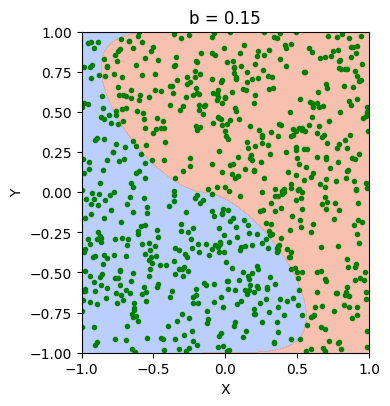

In [12]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
b = 0.15

plt.figure(figsize=(4, 4))

decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)
plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

contexts = np.array( [ context_generator.denormalize(i) for i in X_depl ] ).squeeze(1) 

# action0 = [ i[0] if i[0]==2 else np.nan for i in history ]
# indices_action0 = np.where(~np.isnan(action0))[0]
# contexts0 = contexts[indices_action0]

# action1 = [ i[0] if i[0]==1 else np.nan for i in history ]
# indices_action1 = np.where(~np.isnan(action1))[0]
# contexts1 = contexts[indices_action1]

action2 = [ i[0] if i[0]==0 else np.nan for i in history ]
indices_action2 = np.where(~np.isnan(action2))[0]
contexts2 = contexts[indices_action2]

action2 = [ i[0] if i[0]==0 else np.nan for i in history ]
indices_action2 = np.where(~np.isnan(action2))[0]
contexts2 = contexts[indices_action2]

# plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'orange')
# plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'blue')
plt.plot(contexts2[:,0], contexts2[:,1], '.', color = 'green')
# plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='blue', label='Predicted Points')
# plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='red', label='Predicted Points')
# Add labels and title to the plot
plt.xlabel('X')
plt.ylabel('Y')
# plt.title(' Decision Boundary')
# Adjust the layout for better spacing
plt.tight_layout()
plt.ylim((-1,1))
plt.xlim((-1,1))
plt.title('b = {}'.format(b))
# Save the figure to a file with tight layout and 380 DPI
# plt.savefig('./figures/decision_boundary_{}.png'.format(idx), dpi=380, bbox_inches='tight')

In [4]:
history_eval = [] 
cumRegret2 =  np.zeros(len(y_depl2), dtype =float)
t = 0
for context, outcome, distribution in zip(X_depl2, y_depl2, dist_depl2):

    context = context.reshape((1,-1))

    outcome = outcome[0]

    action, data = alg.get_action(t, context, 'eval')

    history_eval.append( data )
    print('t', t, 'action', action, 'outcome', outcome, )

    i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
    loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
    val = loss_diff @ np.array( distribution )
    cumRegret2[t] =  val
    t+=1

t 0 action 0 outcome 0
t 1 action 1 outcome 1
t 2 action 2 outcome 0
factor 3.0594560613513186 width [[0.20516569]]
factor 1.99399116223721 width [[1.03594387]]
factor 0.398798232447442 width [[0.38326338]]
pair [1, 2] tdelta [0.83660592] confidence [[0.62769542]]
union1 [2] R []
t 3 action 2 outcome 0
factor 0.0 width [[0.16799431]]
factor 0.0 width [[0.82917612]]
factor 2.3846767806204925 width [[0.30608406]]
pair [1, 2] tdelta [-0.03354643] confidence [[0.]]
union1 [1] R []
t 4 action 1 outcome 1
factor 1.0154650660310358 width [[0.2049984]]
factor 1.1898642657132206 width [[1.0348156]]
factor 1.5864856876176274 width [[0.38295074]]
pair [1, 2] tdelta [0.83704355] confidence [[0.20816871]]
union1 [2] R []
t 5 action 2 outcome 0
factor 5.071769783089197 width [[0.13880745]]
factor 1.5842634687912343 width [[0.69548999]]
factor 0.0 width [[0.29551717]]
pair [1, 2] tdelta [0.6977317] confidence [[0.70399941]]
union1 [2] R []
t 6 action 2 outcome 1
factor 1.0135545798834558 width [[0.16

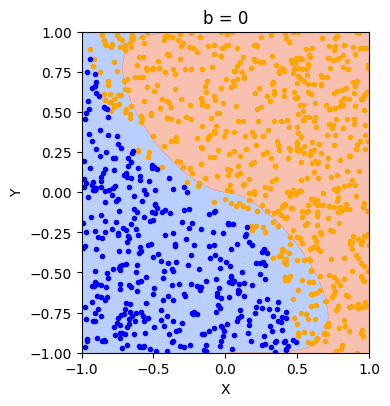

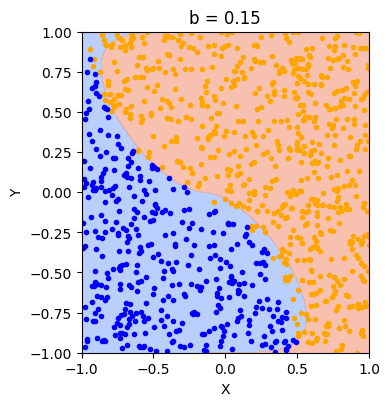

In [29]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
for b in [0, 0.15]:

    plt.figure(figsize=(4, 4))

    decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)

    plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

    contexts = np.array( [ context_generator.denormalize(i) for i in X_depl2 ] ).squeeze(1) 

    action0 = [ i[0] if i[0]==2 else np.nan for i in history_eval ]
    indices_action0 = np.where(~np.isnan(action0))[0]
    contexts0 = contexts[indices_action0]
    action1 = [ i[0] if i[0]==1 else np.nan for i in history_eval ]
    indices_action1 = np.where(~np.isnan(action1))[0]
    contexts1 = contexts[indices_action1]

    plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'orange')
    plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'blue')

    # plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='blue', label='Predicted Points')
    # plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='red', label='Predicted Points')

    # Add labels and title to the plot
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title(' Decision Boundary')
    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.ylim((-1,1))
    plt.xlim((-1,1))
    plt.title('b = {}'.format(b))

    # Save the figure to a file with tight layout and 380 DPI
    # plt.savefig('./figures/decision_boundary_{}.png'.format(idx), dpi=380, bbox_inches='tight')

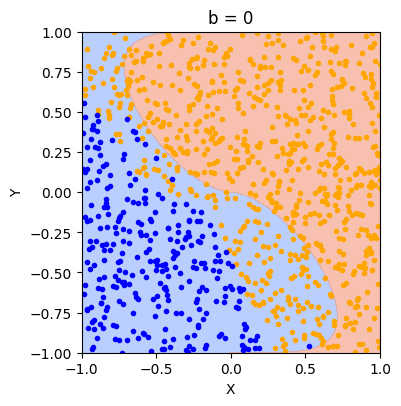

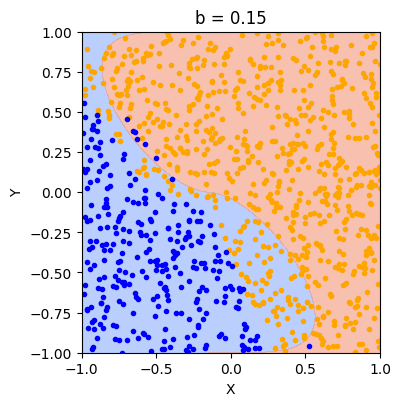

In [5]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
for b in [0, 0.15]:

    plt.figure(figsize=(4, 4))

    decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)

    plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

    contexts = np.array( [ context_generator.denormalize(i) for i in X_depl2 ] ).squeeze(1) 

    action0 = [ i[0] if i[0]==2 else np.nan for i in history_eval ]
    indices_action0 = np.where(~np.isnan(action0))[0]
    contexts0 = contexts[indices_action0]
    action1 = [ i[0] if i[0]==1 else np.nan for i in history_eval ]
    indices_action1 = np.where(~np.isnan(action1))[0]
    contexts1 = contexts[indices_action1]

    plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'orange')
    plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'blue')

    # plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='blue', label='Predicted Points')
    # plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='red', label='Predicted Points')

    # Add labels and title to the plot
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title(' Decision Boundary')
    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.ylim((-1,1))
    plt.xlim((-1,1))
    plt.title('b = {}'.format(b))

    # Save the figure to a file with tight layout and 380 DPI
    # plt.savefig('./figures/decision_boundary_{}.png'.format(idx), dpi=380, bbox_inches='tight')

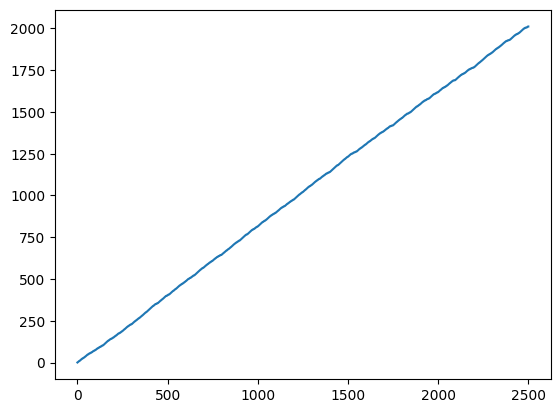

In [30]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(cumRegret))

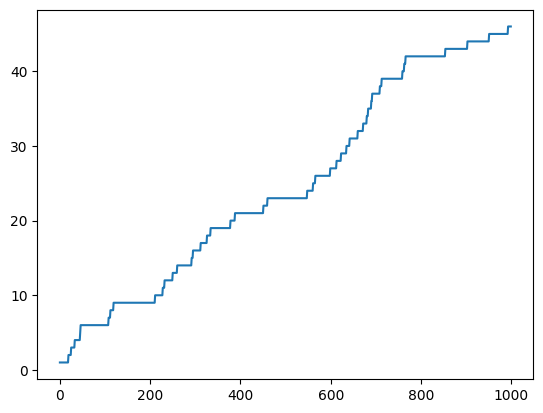

In [31]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(cumRegret2))

In [6]:
alg.contexts[0]['weights'][0]

array([-1.55285636e-01,  9.58574309e-03, -4.83533851e-03,  5.51693882e-05,
        6.04287566e-02, -8.43534577e-03,  4.69047792e-01, -1.86971190e-02,
        9.32407752e-04, -1.18251612e-02, -8.26114244e-03,  3.96087246e-03,
        1.00466743e-02,  5.05909681e-01, -8.59160144e-02,  1.94987104e-03,
        1.92741178e-05,  4.37133534e-03,  9.65233802e-02,  4.35256315e-01])

Text(0, 0.5, 'Loss')

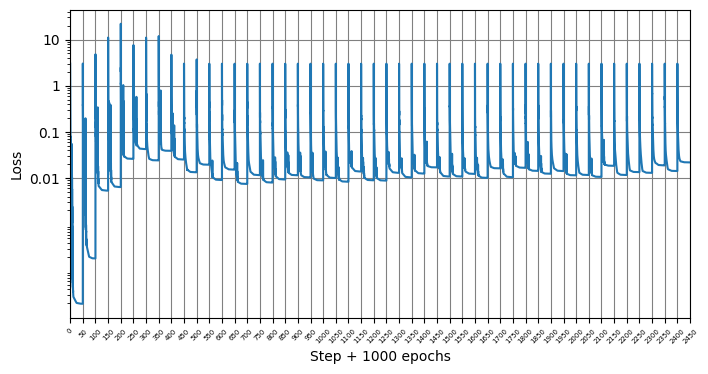

In [9]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.hstack( [ i for i in global_loss if len(i)>0 ] )

plt.figure(figsize=(8, 4))
# plt.ylim( (0, 10) )
plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, len(new_global_loss)) )


def generate_custom_ticks(start, horizon, end, increment, label_increment):
    custom_ticks = list(range(start, end+1 , increment))
    custom_tick_labels = [ str(i) for i in range(start, horizon , label_increment)]
    return custom_ticks, custom_tick_labels

# Define the parameters
start_value = 0
end_value = len(new_global_loss) 
tick_increment = 1000
label_increment = 50
horizon = 2500

custom_ticks, custom_tick_labels = generate_custom_ticks(start_value, horizon, end_value, tick_increment, label_increment)

plt.xticks(custom_ticks, custom_tick_labels, rotation=45, fontsize=5)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss )
plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')

# plt.savefig('./figures/loss_evolution.png', dpi=380, bbox_inches='tight')


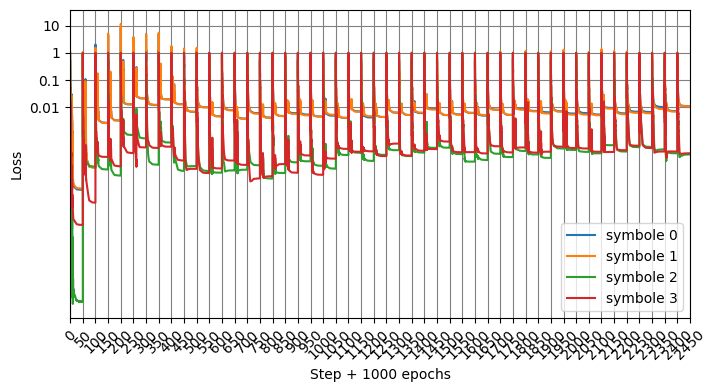

In [10]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.vstack( [ i for i in global_losses if len(i)>0 ] )

plt.figure(figsize=(8, 4))

plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, 19000) )

plt.xticks(custom_ticks, custom_tick_labels, rotation=45)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss[:,0], label = 'symbole 0' )
plt.plot( new_global_loss[:,1], label = 'symbole 1' )
plt.plot( new_global_loss[:,2], label = 'symbole 2' )
plt.plot( new_global_loss[:,3], label = 'symbole 3' )

plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')
plt.legend()

# plt.savefig('./figures/loss_evolution_{}.png'.format(idx), dpi=380, bbox_inches='tight')


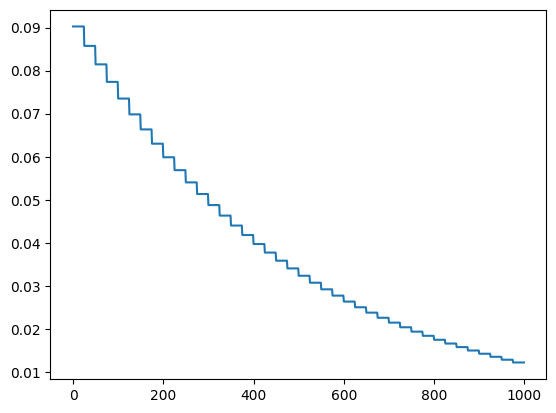

In [24]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.Adam(alg.func.parameters(), lr=0.1, weight_decay = 0 )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
# scheduler = StepLR(optimizer, step_size=250, last_epoch=- 1, gamma=0.1)
values = []

for _ in range(1000):

    if _ % 25 == 0 :
        scheduler.step()

    lr_value = scheduler.get_lr()[0]
    values.append(lr_value)

plt.plot(range(1000), values)
# plt.yscale('log')

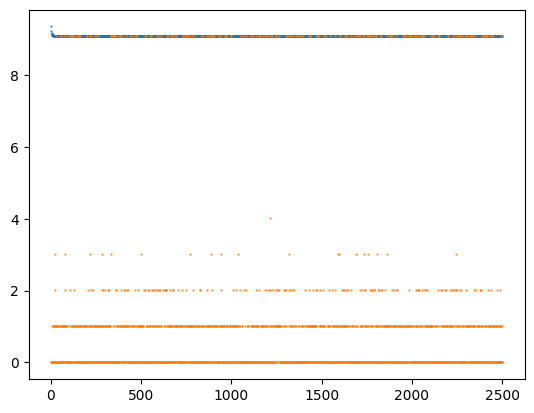

In [66]:


def obtain_probability(t , factor):

    sigma = 1
    K = 10
    epsilon = 0.1#10e-7

    def divide_interval(start, end, k):
        intervals = np.linspace(start, end, k).tolist()
        return intervals

    # U = np.sqrt( self.alpha  * np.log(t) ) 

    U =  factor
    rhos = divide_interval(0, U, K)
    p_m_hat =  np.array([ np.exp( -(rhos[i]**2) / 2*(sigma**2)  )  for i in range(len(rhos)-1) ] )
    p_m = (1 - epsilon) * p_m_hat / p_m_hat.sum()
    p_m = p_m.tolist()
    p_m.append(epsilon)
        
    Z = np.random.choice(rhos, p= p_m)
    return Z

deterministic = []
rand = []

for t in range(1, 2500):
    sigma_i = 2
    d = 2
    N = 3
    H = 50
    lbd_reg = 1
    factor = sigma_i * (  np.sqrt( 2 * ( d  * np.log( 1 + t * np.log(N * H)/lbd_reg ) +  np.log(1/t**2) ) ) + np.sqrt(lbd_reg) * sigma_i )
    rand_value = obtain_probability(t , factor)
    deterministic.append(factor)
    rand.append(rand_value)


plt.plot(range(1,2500), deterministic, '.', markersize = 1)

plt.plot(range(1,2500), rand, '.', markersize = 1)


(array([1.362e+03, 7.500e+02, 1.380e+02, 1.900e+01, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.290e+02]),
 array([0.        , 0.90886871, 1.81773743, 2.72660614, 3.63547486,
        4.54434357, 5.45321229, 6.362081  , 7.27094972, 8.17981843,
        9.08868714]),
 <BarContainer object of 10 artists>)

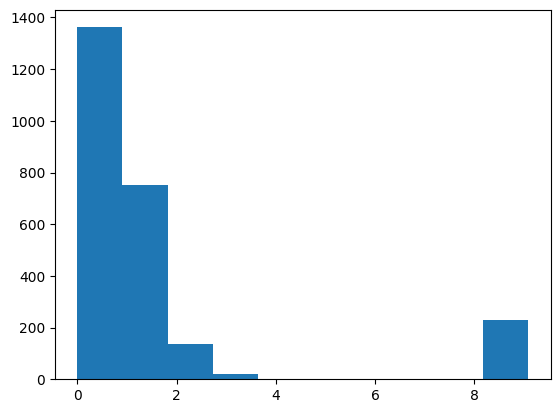

In [67]:
plt.hist(rand, bins = 10)

In [13]:
alg.func()

array([1., 0., 0.])

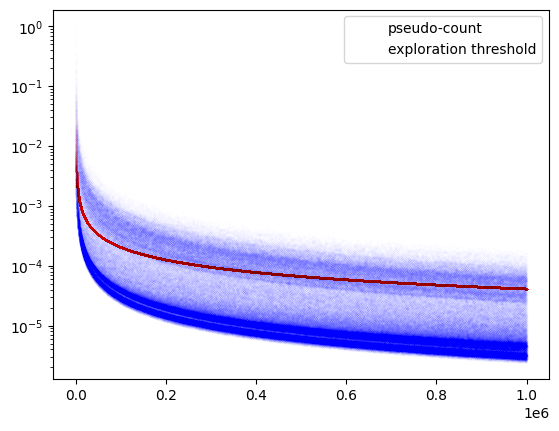

In [43]:
# context_generator = synthetic_data.QuinticContexts(  )
# context_generator.set_b(0)
# context_generator.normalization()

# V_it_inv = np.identity(20)

# vals = []
# rates = []

# T = 1000000

# for t in range(1,T):

#     norm_context, distribution = context_generator.get_context(True)
#     dist_test.append(distribution)
#     outcome = np.random.choice( 2 , p = distribution ) 

#     latent_X = alg.func( torch.from_numpy( norm_context ).float().to(alg.device) ).cpu().detach().numpy()

#     V_it_inv = V_it_inv - ( V_it_inv @ latent_X.T @ latent_X @ V_it_inv ) / ( 1 + latent_X @ V_it_inv @ latent_X.T ) 

#     val =  latent_X @ V_it_inv @ latent_X.T  
#     rate = t**(2/3)  * ( 1.01 * np.log(t) )**(1/3)

#     vals.append(val[0][0])
#     rates.append(1/rate)

plt.plot(range(1,T), vals, '.' , markersize = 0.01, color = 'blue', label = 'pseudo-count')
plt.plot(range(1,T), rates, '.', markersize = 0.01, color = 'red', label = 'exploration threshold')
plt.yscale('log')
plt.legend()